In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.regression.linear_model import OLS
from scipy.signal import periodogram

## Loading data

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


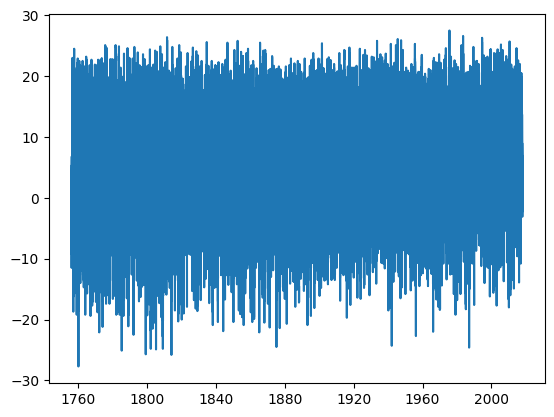

In [71]:
all_data=pd.read_csv("stockholm_daily_mean_temperature_1756_2017.txt",sep="\s+",header=None,usecols=[0,1,2,5],names=["Year","Month","Day","Temperature"])
all_data["Date"]=pd.to_datetime(all_data[["Year","Month","Day"]])
all_data.set_index("Date",inplace=True)
display(all_data)
plt.plot(all_data.index,all_data["Temperature"])
plt.show()
validation_data=all_data.tail(365*2+1)
data=all_data.head(-365*2-1)

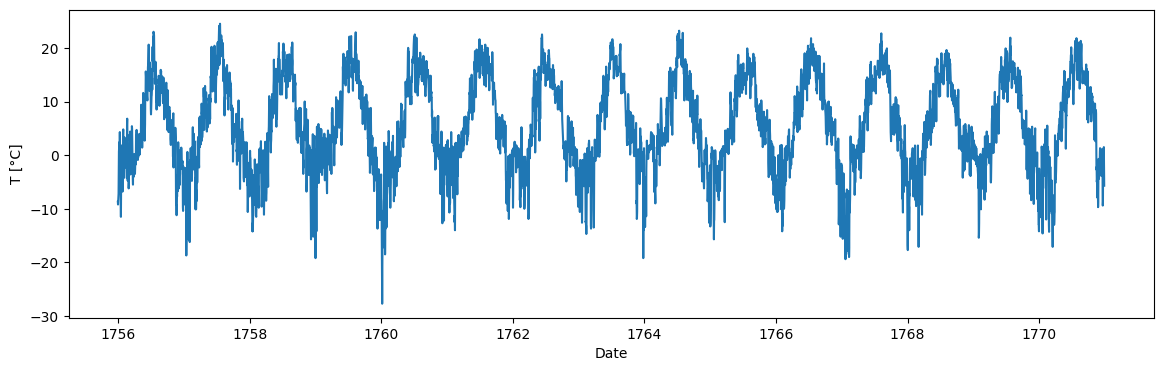

In [72]:
#Zooming in looking for periodicty
first_samples=data.head(365*15)
fig=plt.figure(figsize=(14,4))
plt.plot(first_samples.index,first_samples["Temperature"])
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.savefig("A_series")
plt.show()

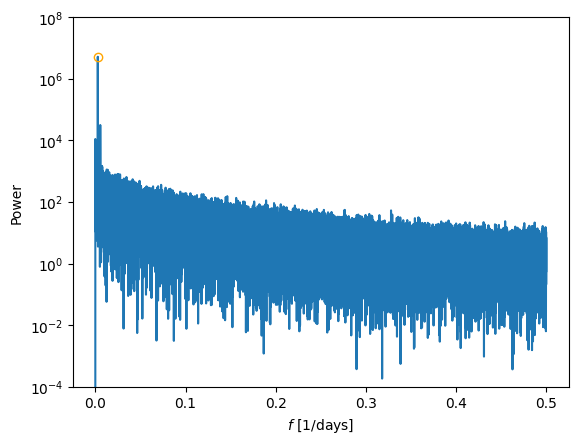

The peak is at 0.0027378937028444835 which corresponds to a period of 365.2442748091603 days.


In [4]:

f, px =periodogram(data["Temperature"])
plt.plot(f,px)
plt.yscale("log")
plt.ylim([1E-4,1E8])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()
print("The peak is at",max_f,"which corresponds to a period of",1/max_f,"days.")


## Cleaning the data

In [74]:
data["diff"] = data['Temperature'] - data['Temperature'].shift(365*4+1)
data_cleaned = data["diff"].dropna()

C:\Users\Xindi Liu\AppData\Local\Temp\ipykernel_11344\2100172214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["diff"] = data['Temperature'] - data['Temperature'].shift(365*4+1)


0.004533462821696865
5.2211762363434


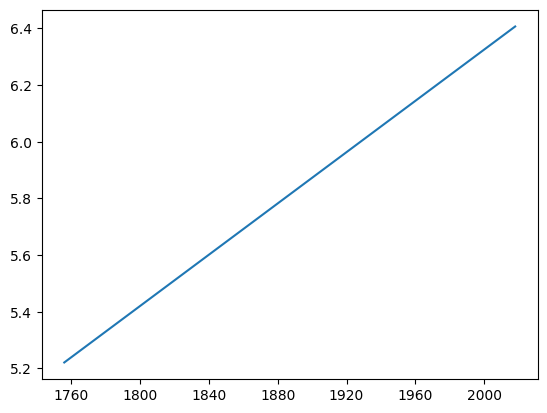

In [5]:
#Removing linear trend
data_detrended=detrend(data["Temperature"],order=1)
#We can see the linear model by
trend=data["Temperature"]-data_detrended
trend_coefficient = trend["1757-1-1"] -  trend["1756-1-1"]
trend_const = trend.iloc[0]
print(trend_coefficient)
print(trend_const)
plt.plot(trend.index,trend)
plt.show()

In [75]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
	
adf_test(data_cleaned)
kpss_test(data_cleaned)

Results of Dickey-Fuller Test:
Test Statistic                   -33.383176
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    93454.000000
Critical Value (1%)               -3.430420
Critical Value (5%)               -2.861571
Critical Value (10%)              -2.566786
dtype: float64
Results of KPSS Test:
Test Statistic             0.035734
p-value                    0.100000
Lags Used                138.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Fitting ARMA Models

c:\Program Files\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


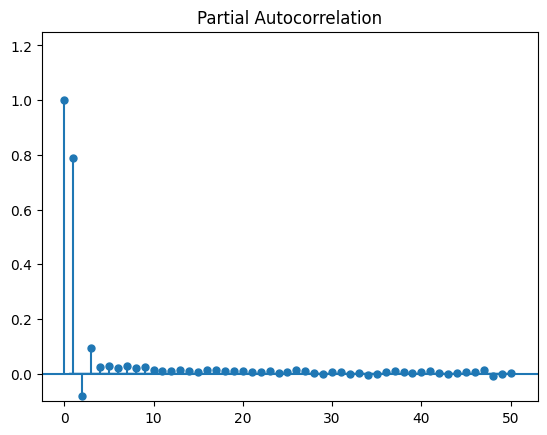

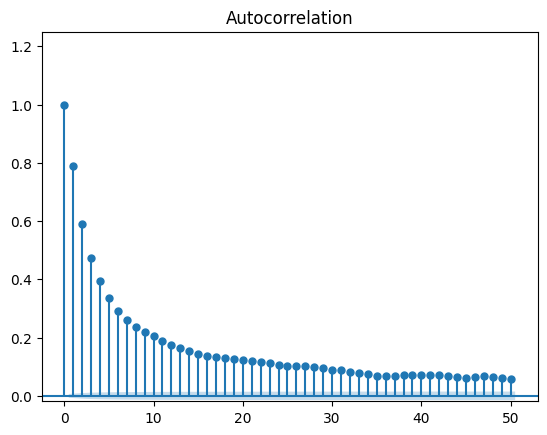

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from pmdarima import auto_arima

##Plot the acf and pacf to determine the order
_=plot_pacf(data_cleaned, alpha = 0.05, auto_ylims = True)
_=plot_acf(data_cleaned, alpha = 0.05, auto_ylims= True)
##The ACF decays geometrically, indicating that an ARMA model is suitable for fitting

In [18]:
maxp=3
maxq=5

aiccs=np.zeros((maxp+1,maxq+1)) 
aics=np.zeros((maxp+1,maxq+1)) 
bics=np.zeros((maxp+1,maxq+1)) 

for p in range(0,maxp+1):
  for q in range(0,maxq+1):
    model = ARIMA(data_cleaned, order=(p, 0 ,q)).fit(method= "innovations_mle")
    
    aiccs[p,q]=model.aicc
    aics[p,q]=model.aic
    bics[p,q]=model.bic

'''
ind = np.argmin(aiccs)
model = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")
print(aiccs)
print(orders)
print(orders[ind])
'''

c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

'\nind = np.argmin(aiccs)\nmodel = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")\nprint(aiccs)\nprint(orders)\nprint(orders[ind])\n'

In [77]:
# best_params=np.unravel_index(np.argmin(aiccs), aiccs.shape)
best_params = (3, 3)
print("Best params:  p =",best_params[0],",  q =",best_params[1])
best_model=ARIMA(data_cleaned, order=(best_params[0], 0 ,best_params[1])).fit(method= "innovations_mle")
print("Best params using innovations")
print("ar:",best_model.arparams)
print("ma:",best_model.maparams)

Best params:  p = 3 ,  q = 3


c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best params using innovations
ar: [ 2.00775651 -1.22022073  0.20761275]
ma: [-1.15576219  0.07606583  0.11556963]


In [78]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   diff   No. Observations:                93502
Model:                 ARIMA(3, 0, 3)   Log Likelihood             -242256.244
Date:                Fri, 03 May 2024   AIC                         484528.487
Time:                        12:17:24   BIC                         484604.053
Sample:                    01-01-1760   HQIC                        484551.489
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0319      0.078      0.409      0.683      -0.121       0.185
ar.L1          2.0078      0.064     31.390      0.000       1.882       2.133
ar.L2         -1.2202      0.103    -11.878      0.000      -1.422      -1.019
ar.L3          0.2076      0.040      5.226      0.000       0.130       0.285
ma.L1         -1.1558      0.064    -18.089      0.000      -1.281      -1.031
ma.L2          0.0761      0.049      1.566      0.117      -0.019       0.171
ma.L3          0.1156      0.010     11.058      0.000       0.095       0.136
sigma2        10.4223      0.038    271.177      0.000      10.347      10.498
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5654.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ljung-Box test have p value $0.99 > 0.05$. We cannot reject the null hypothesis that the residuals are independent. 
Jarque-Bera test have p value $0.00<0.05$, so the hypothesis that the residuals are normaly distributed is can be rejected.

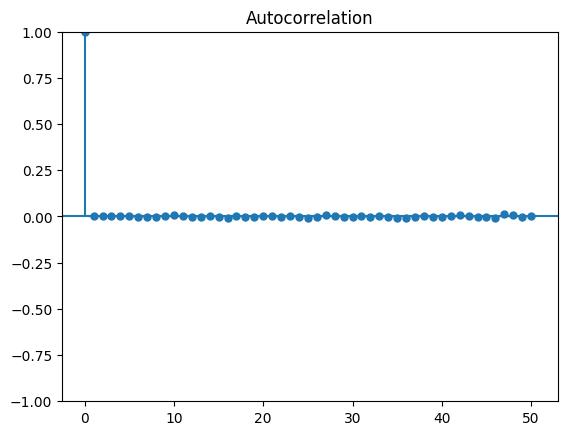

In [79]:
_ = plot_acf(best_model.resid, alpha = 0.05)

Sample ACF inside the bounds $\Rightarrow$ the residuals are iid noise.

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

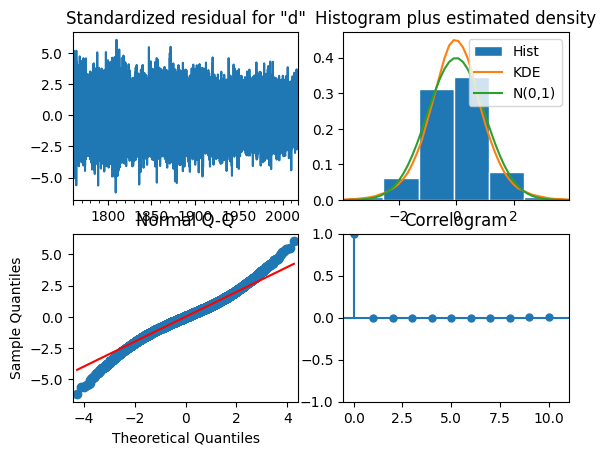

In [23]:
_ = best_model.plot_diagnostics()

## Forecasting

In [80]:
def forecast_out(n):
	period = 365 * 4 + 1
	forecasts = best_model.get_forecast(n).summary_frame()
	index = forecasts.index - pd.to_timedelta(365*4+1, unit='d')
	shift = data.loc[index]['Temperature']
	forecasts['mean'] += shift.values
	forecasts['mean_ci_lower'] += shift.values
	forecasts['mean_ci_upper'] += shift.values
	return forecasts

In [85]:
forecasts = forecast_out(365*2+1)

C:\Users\Xindi Liu\AppData\Local\Temp\ipykernel_11344\4194992584.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


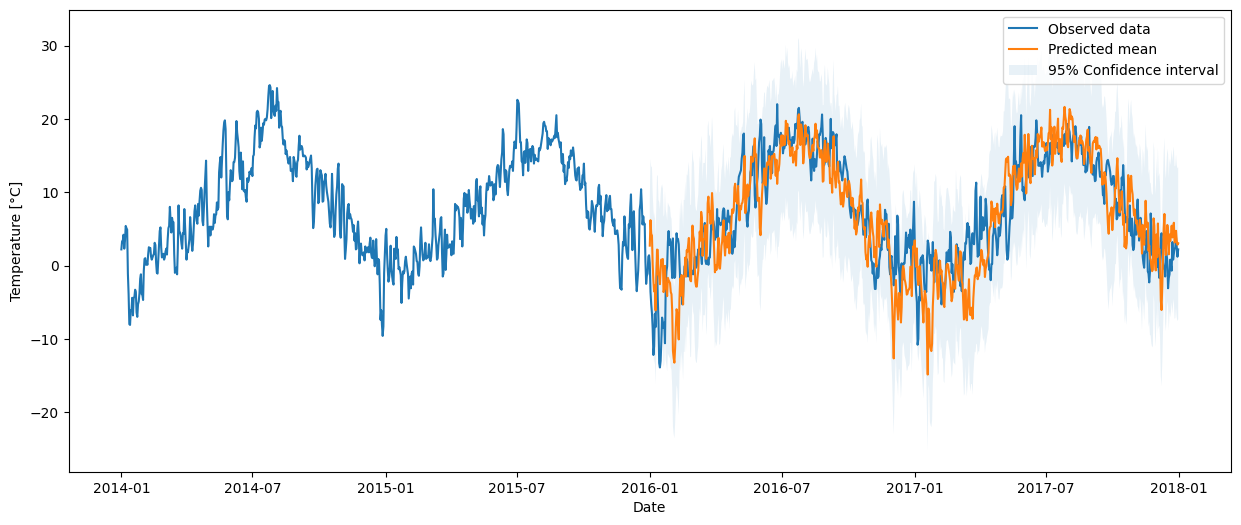

In [86]:
fig = plt.figure(figsize=(15, 6))
plt.plot(pd.concat((data.tail(365*2),validation_data)).index,pd.concat((data.tail(365*2)["Temperature"],validation_data["Temperature"])))
plt.plot(forecasts.index, forecasts['mean'])
plt.fill_between(forecasts.index, forecasts['mean_ci_lower'],forecasts['mean_ci_upper'], alpha = 0.1)
plt.legend(['Observed data','Predicted mean', '95% Confidence interval'])
plt.xlabel('Date')
plt.ylabel('Temperature [°C]')
plt.savefig("A_forecasting")
fig.show()

In [87]:
errors=(validation_data["Temperature"]-forecasts['mean']).to_numpy()
MAE=np.abs(errors).mean()
print("MAE",MAE)
RMSE=np.sqrt((errors**2).mean())
print("RMSE",RMSE)

MAE 3.767709586901092
RMSE 4.813367183890383
